## Integrantes

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from scipy.stats import mstats

In [8]:
file_name = 'diabetes_proyecto.csv'
df = pd.read_csv(file_name)


In [9]:
y = df['Outcome']
y.info()
df = pd.concat([df, pd.get_dummies(df['Lifestyle'], dtype=int)], axis=1).drop(columns=['Lifestyle'])
df = pd.concat([df, pd.get_dummies(df['DietType'], dtype=int)], axis=1).drop(columns=['DietType'])
df = pd.concat([df, pd.get_dummies(df['SmokingStatus'], dtype=int)], axis=1).drop(columns=['SmokingStatus'])
df = pd.concat([df, pd.get_dummies(df['FamilyHistory'], dtype=int)], axis=1).drop(columns=['FamilyHistory'])
df.head()


<class 'pandas.core.series.Series'>
RangeIndex: 144641 entries, 0 to 144640
Series name: Outcome
Non-Null Count   Dtype
--------------   -----
144641 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,StressLevel,Active,Seden,Sedentary,Balanced,HighCarb,LowCarb,Non-Smoker,Smoker,No,Yes
0,6,148.0,72,35,0.0,33.6,0.627,50,1,8.29,1,0,0,1,0,0,1,0,0,1
1,1,85.0,66,29,0.0,26.6,0.351,31,0,3.59,1,0,0,1,0,0,0,1,1,0
2,8,183.0,64,0,0.0,23.3,0.672,32,1,1.73,0,0,1,1,0,0,1,0,0,1
3,1,89.0,66,23,94.0,28.1,0.167,21,0,6.22,0,0,1,1,0,0,1,0,1,0
4,0,137.0,40,35,168.0,43.1,2.288,33,1,6.79,1,0,0,0,0,1,1,0,0,1


Resumen inicial (df_proc):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144641 entries, 0 to 144640
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Pregnancies               144641 non-null  int64  
 1   Glucose                   140290 non-null  float64
 2   BloodPressure             144641 non-null  int64  
 3   SkinThickness             144641 non-null  int64  
 4   Insulin                   143200 non-null  float64
 5   BMI                       144641 non-null  float64
 6   DiabetesPedigreeFunction  144641 non-null  float64
 7   Age                       144641 non-null  int64  
 8   Outcome                   144641 non-null  int64  
 9   StressLevel               137381 non-null  float64
 10  Active                    144641 non-null  int32  
 11  Seden                     144641 non-null  int32  
 12  Sedentary                 144641 non-null  int32  
 13  Balanced         

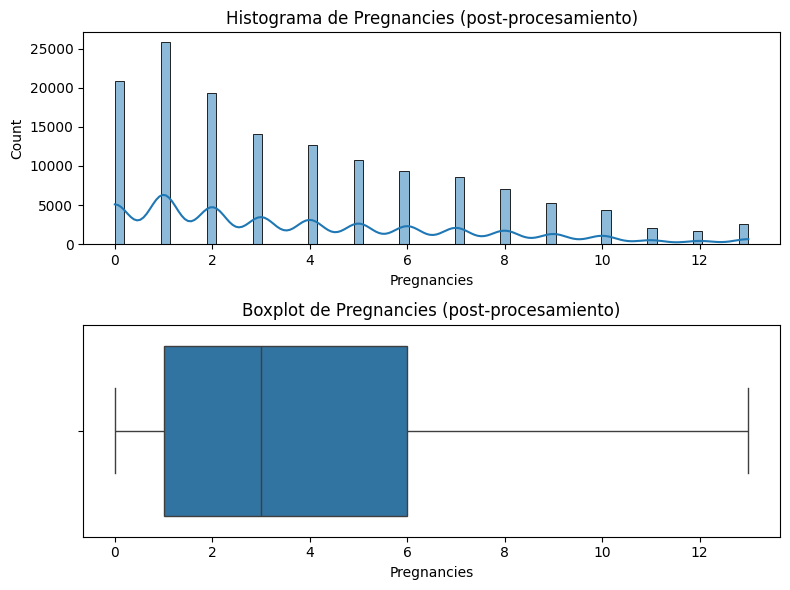

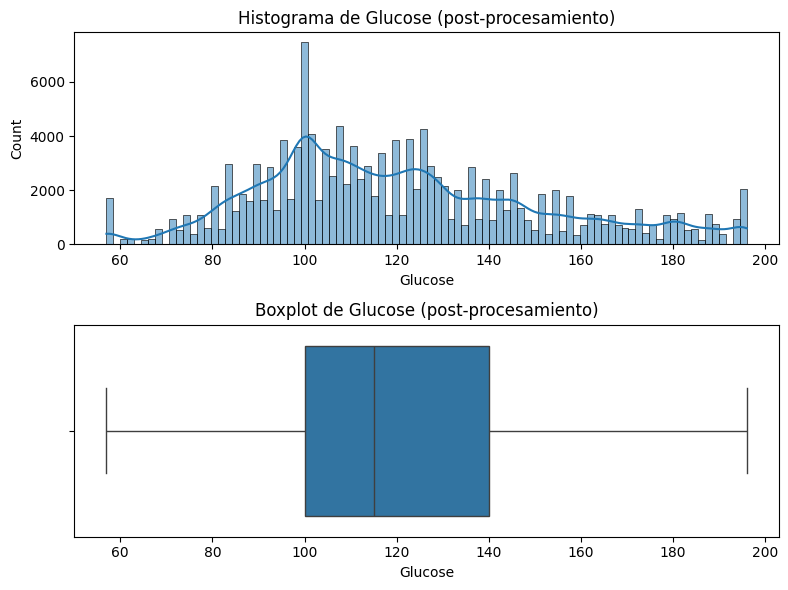

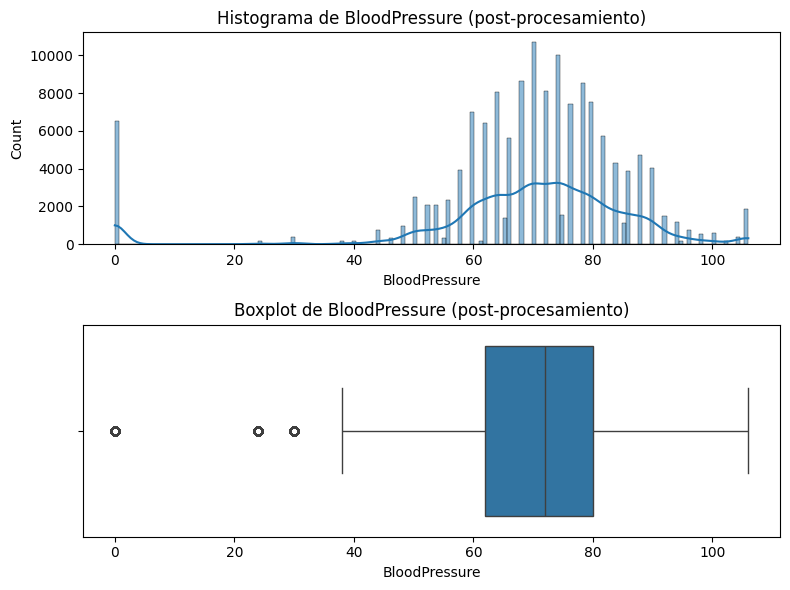

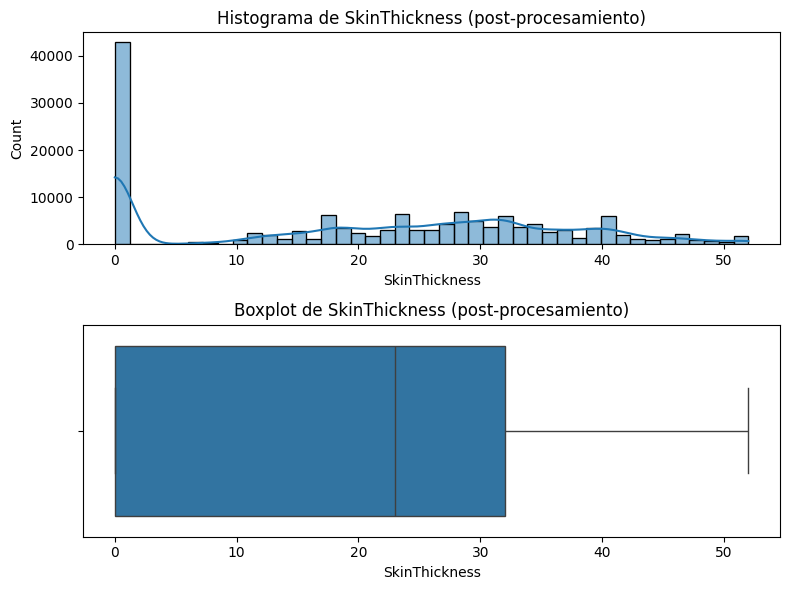

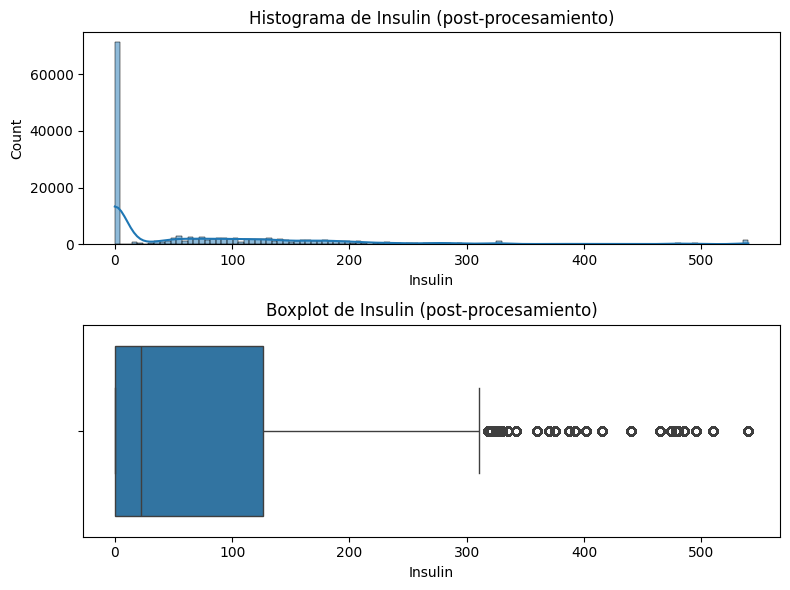

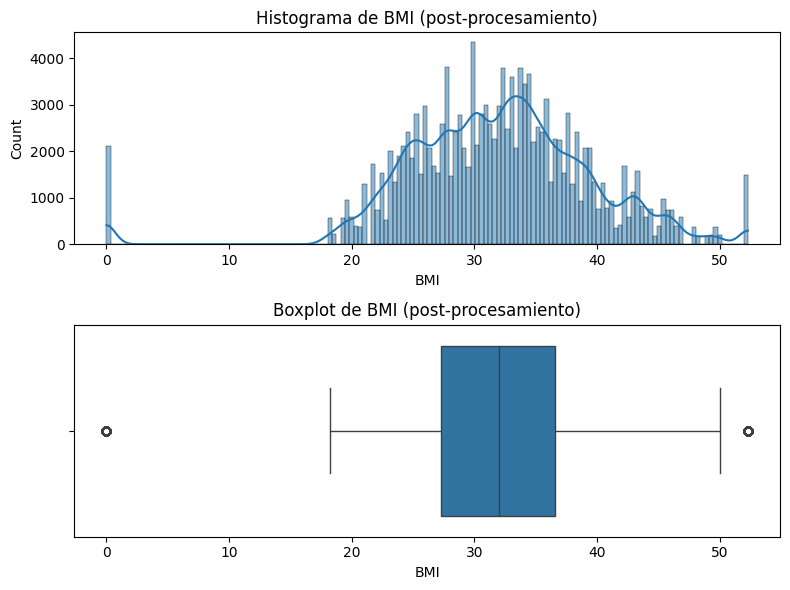

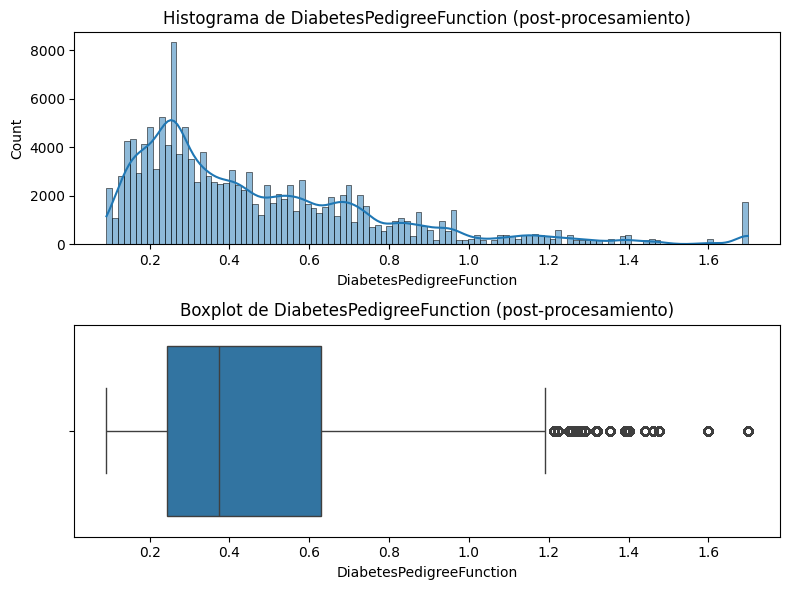

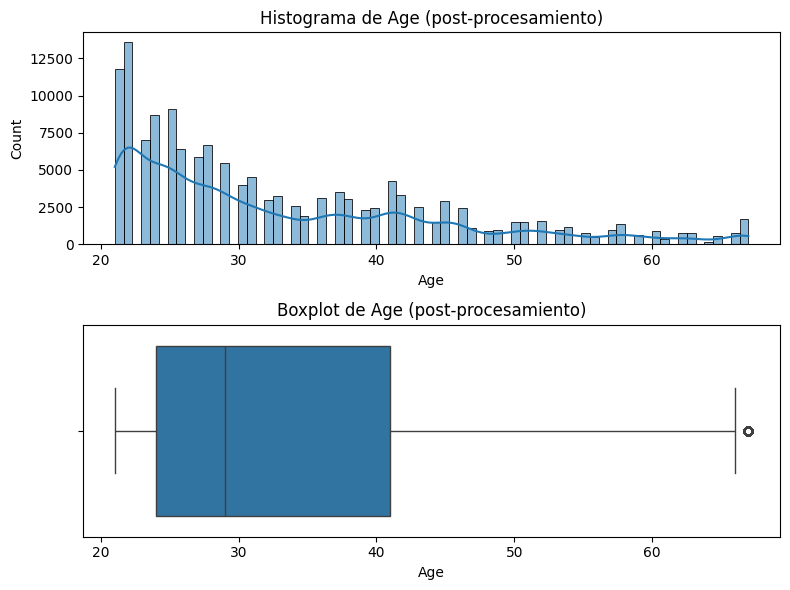

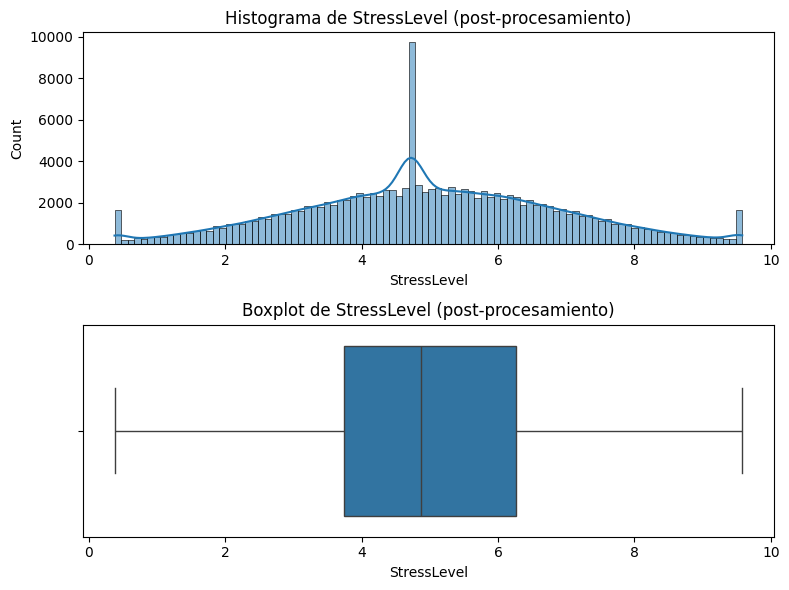

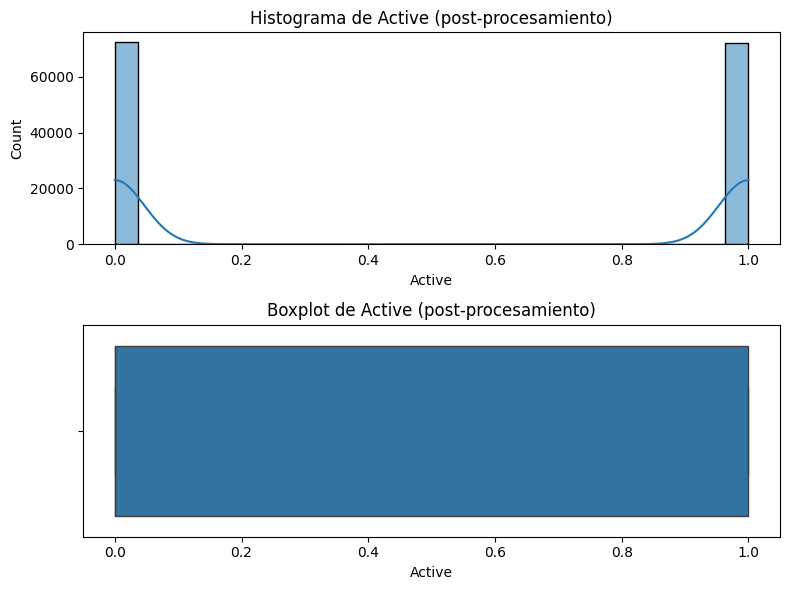

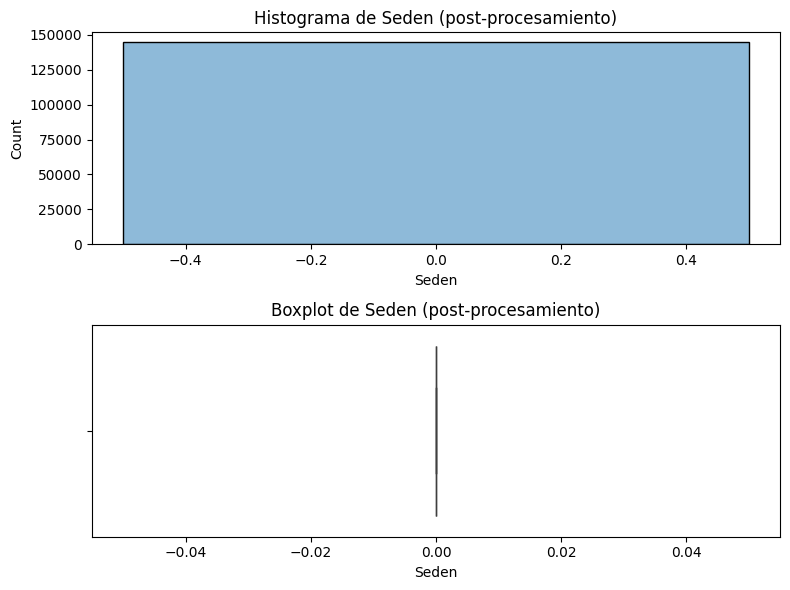

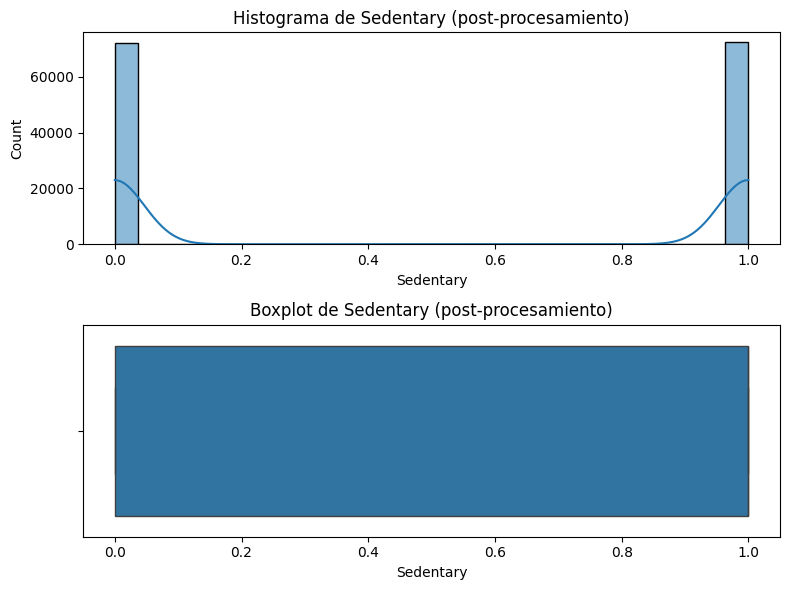

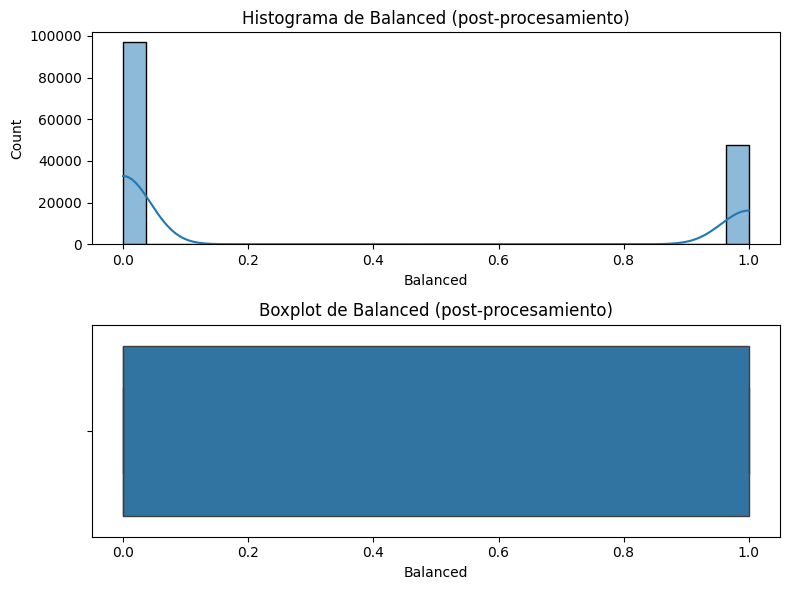

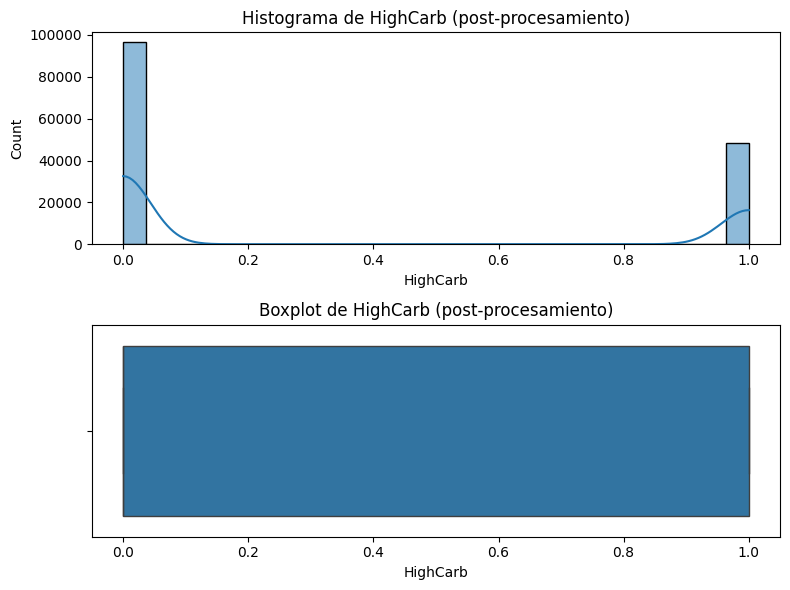

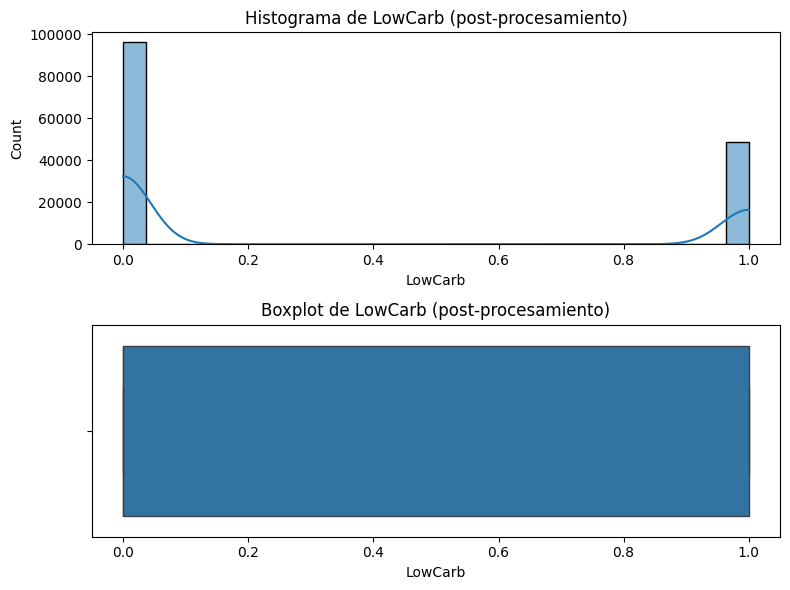

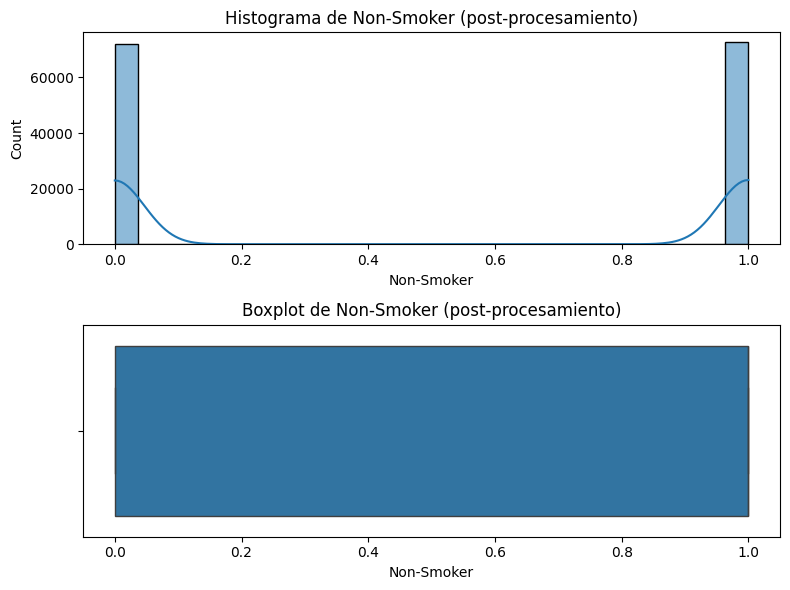

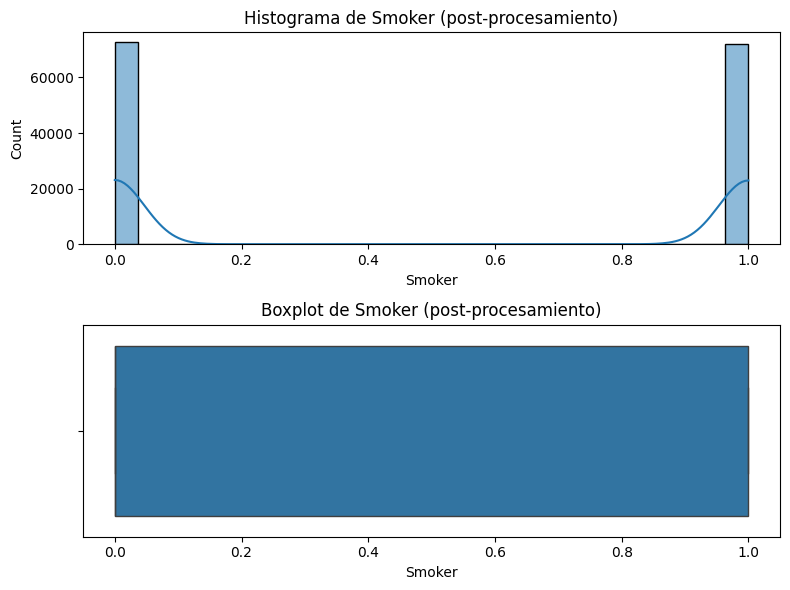

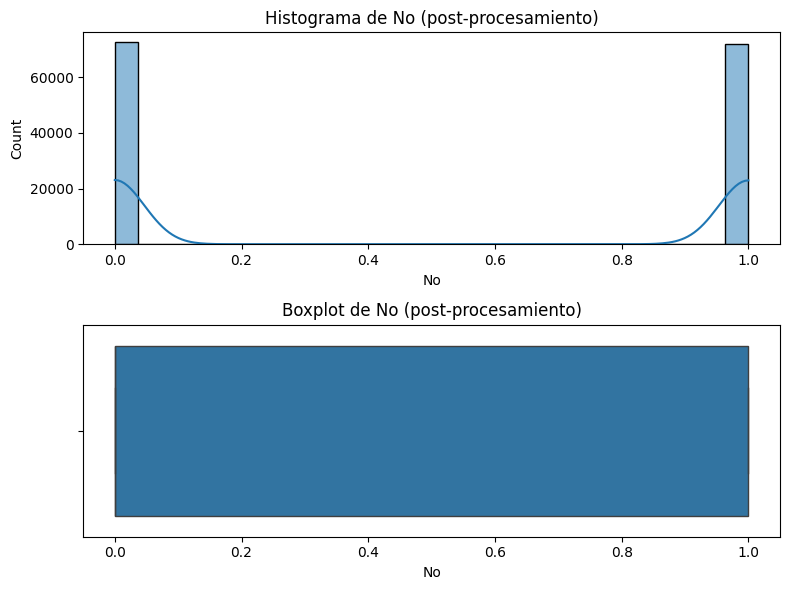

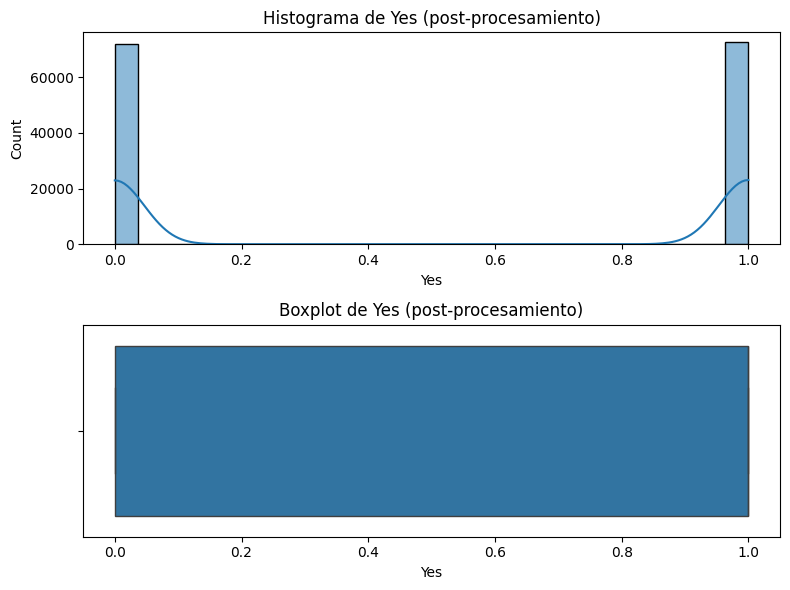

Preprocesamiento columna por columna finalizado. df -> df_proc -> df
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144641 entries, 0 to 144640
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Pregnancies               144641 non-null  float64
 1   Glucose                   144641 non-null  float64
 2   BloodPressure             144641 non-null  float64
 3   SkinThickness             144641 non-null  float64
 4   Insulin                   144641 non-null  float64
 5   BMI                       144641 non-null  float64
 6   DiabetesPedigreeFunction  144641 non-null  float64
 7   Age                       144641 non-null  float64
 8   Outcome                   144641 non-null  int64  
 9   StressLevel               144641 non-null  float64
 10  Active                    144641 non-null  float64
 11  Seden                     144641 non-null  float64
 12  Sedentary                 14464

In [10]:

# ==================== PREPROCESAMIENTO COLUMNA POR COLUMNA ====================
# Basado en el estilo del notebook: imputación con SimpleImputer(strategy='most_frequent'),
# conversión numérica con errors='coerce', winsorización de extremos (1% por cola),
# y visualización con histogramas y boxplots. No se crean features nuevas ni se eliminan filas.

from sklearn.impute import SimpleImputer
from scipy.stats import mstats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un dataframe procesado independiente desde el df con dummies
df_proc = df.copy()

# Separar target si existe en columnas
target_col = 'Outcome' if 'Outcome' in df_proc.columns else None
if target_col is not None:
    y = df_proc[target_col]
else:
    y = None

print("Resumen inicial (df_proc):")
print(df_proc.info())
print(df_proc.head())
print("-"*100)

# Intento de conversión a numérico para columnas object/categoría que sean numéricas en texto
for col in df_proc.columns:
    if col == target_col:
        continue
    if df_proc[col].dtype == 'object':
        # Conversión tentativa a numérico
        before_na = df_proc[col].isna().sum()
        df_proc[col] = pd.to_numeric(df_proc[col], errors='coerce')
        after_na = df_proc[col].isna().sum()
        print(f"[{col}] object -> numeric (coerce). NaN antes: {before_na}, después: {after_na}")

print("-"*100)
print("Tipos luego de convertir a numérico donde aplica:")
print(df_proc.dtypes)

# Imputación por moda para TODAS las columnas (como en el notebook), respetando estilo
# (el cuaderno usa 'most_frequent' para columnas problemáticas como 'ca' y 'thal'. Aquí generalizamos.)
imputer_mode = SimpleImputer(strategy='most_frequent')
cols_to_impute = [c for c in df_proc.columns if c != target_col]
df_proc[cols_to_impute] = imputer_mode.fit_transform(df_proc[cols_to_impute])

print("-"*100)
print("Después de imputación por moda:")
print(df_proc.isna().sum())

# Winsorización (1% por cola) para columnas numéricas (excepto la etiqueta)
num_cols = [c for c in df_proc.select_dtypes(include=[np.number]).columns if c != target_col]

for col in num_cols:
    # Registrar cuantiles antes
    q1, q99 = df_proc[col].quantile(0.01), df_proc[col].quantile(0.99)
    df_proc[col] = mstats.winsorize(df_proc[col], limits=[0.01, 0.01])
    print(f"[{col}] winsorize 1%-99% | q01={q1:.4f}, q99={q99:.4f}")

print("-"*100)
print("Descripción estadística post-winsorización:")
print(df_proc[num_cols].describe())

# Visualizaciones por columna numérica (histograma + boxplot)
for col in num_cols:
    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    sns.histplot(df_proc[col], kde=True, ax=ax[0])
    ax[0].set_title(f"Histograma de {col} (post-procesamiento)")
    sns.boxplot(x=df_proc[col], ax=ax[1])
    ax[1].set_title(f"Boxplot de {col} (post-procesamiento)")
    plt.tight_layout()
    plt.show()

# Reasignar df si quieres que el resto del notebook use el DataFrame procesado
df = df_proc.copy()

print("Preprocesamiento columna por columna finalizado. df -> df_proc -> df")
print(df.info())


## 1. Preprocesamiento de datos

In [2]:
# === Bloque completo y robusto para preprocesamiento (evita NameError de X/y) ===
# Requiere: pandas, numpy, matplotlib, seaborn, scikit-learn, scipy

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from scipy.stats import mstats

# ---------------------------------------------------------------------
# 1) Cargar/ubicar el DataFrame y detectar columna objetivo
#    - Usa df si ya existe en el entorno
#    - Si no existe y hay un 'heart.csv' en el directorio actual, lo carga
#    - Detecta automáticamente la columna objetivo entre ['num','target','output','disease']
# ---------------------------------------------------------------------
try:
    df  # noqa: F821
except NameError:
    if os.path.exists("heart.csv"):
        df = pd.read_csv("heart.csv")
    else:
        raise NameError(
            "No existe 'X' ni 'y' y tampoco encuentro 'df' ni 'heart.csv'. "
            "Define df manualmente o coloca 'heart.csv' en el directorio de trabajo."
        )

# Copia para no mutar referencias externas
df = df.copy()

# Intentar detectar columna objetivo típica del dataset de Heart Disease
candidate_targets = ["num", "target", "output", "disease"]
target_col = None
for c in candidate_targets:
    if c in df.columns:
        target_col = c
        break
# Si no se encuentra, por defecto usa la última columna
if target_col is None:
    target_col = df.columns[-1]

# ---------------------------------------------------------------------
# 2) Separar X e y
# ---------------------------------------------------------------------
X = df.drop(columns=[target_col]).copy()
y = df[[target_col]].copy()  # mantener como DataFrame de 1 columna, compatible con tu código

print("Datos antes del preprocesamiento:\n")
print(X.info())
print(y.info())
print(X.head())
print(y.head())
print("-------------------------------------------------------------------------------------------------------\n")

# ---------------------------------------------------------------------
# 3) Conversión a numérico (errores → NaN) para columnas que suelen venir como 'object'
#    En el dataset UCI Heart, 'ca' y 'thal' a veces llegan como strings ("?")
# ---------------------------------------------------------------------
for col in ["ca", "thal"]:
    if col in X.columns:
        X.loc[:, col] = pd.to_numeric(X[col], errors="coerce")

# Imputar 'ca' y 'thal' por moda si existen
cols_mode = [c for c in ["ca", "thal"] if c in X.columns]
if cols_mode:
    imputer_mode = SimpleImputer(strategy="most_frequent")
    X.loc[:, cols_mode] = imputer_mode.fit_transform(X[cols_mode])

# ---------------------------------------------------------------------
# 4) Visualización de outliers (antes)
# ---------------------------------------------------------------------
print("Boxplots antes del preprocesamiento:\n")
columns_cont_default = ["age", "trestbps", "chol", "thalach", "oldpeak"]
columns_cont = [c for c in columns_cont_default if c in X.columns]

if len(columns_cont) > 0:
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(columns_cont, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(data=X, y=col)
        plt.title(f'Boxplot de {col}')
    plt.tight_layout()
    plt.show()
else:
    print("No se encontraron columnas continuas esperadas para boxplots (age, trestbps, chol, thalach, oldpeak).")

print("-------------------------------------------------------------------------------------------------------\n")

# ---------------------------------------------------------------------
# 5) Codificación one-hot de categóricas
# ---------------------------------------------------------------------
categorical_cols_default = ["cp", "restecg", "slope", "thal"]
categorical_cols = [c for c in categorical_cols_default if c in X.columns]

if categorical_cols:
    X = pd.get_dummies(X, columns=categorical_cols, dtype=int)

# ---------------------------------------------------------------------
# 6) Escalamiento con RobustScaler en columnas continuas
# ---------------------------------------------------------------------
if columns_cont:
    scaler = RobustScaler()
    X[columns_cont] = X[columns_cont].astype(float)
    X.loc[:, columns_cont] = scaler.fit_transform(X[columns_cont])

# ---------------------------------------------------------------------
# 7) Tratamiento de outliers (winsorize al 1% en cada cola) para continuas
# ---------------------------------------------------------------------
for column in columns_cont:
    X[column] = mstats.winsorize(X[column], limits=[0.01, 0.01])

# ---------------------------------------------------------------------
# 8) Transformación binaria de y (0 = sano, 1 = enfermo [1–4])
#    Aplica solo si y es numérica/entera y tiene valores >1 (como el 'num' 0..4 del UCI)
# ---------------------------------------------------------------------
if y.dtypes.iloc[0] != "int64" and y.dtypes.iloc[0] != "int32":
    # intentar convertir a int si viene en otro tipo
    y.iloc[:, 0] = pd.to_numeric(y.iloc[:, 0], errors="coerce").fillna(0).astype(int)

# Si tiene múltiples niveles (0..4), colapsar a binario
if y.iloc[:, 0].max() > 1:
    y.iloc[:, 0] = y.iloc[:, 0].apply(lambda x: 0 if x == 0 else 1)

# ---------------------------------------------------------------------
# 9) Resultado final
# ---------------------------------------------------------------------
print("Datos preprocesados:\n")
print(X.info())
print(y.info())
print(X.head())
print(y.head())
print("-------------------------------------------------------------------------------------------------------\n")

# ---------------------------------------------------------------------
# 10) Visualización de outliers después del tratamiento
# ---------------------------------------------------------------------
print("Boxplots con datos preprocesados:\n")
if columns_cont:
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(columns_cont, 1):
        plt.subplot(2, 3, i)
        sns.boxplot(data=X, y=col)
        plt.title(f'Boxplot de {col} después del tratamiento')
    plt.tight_layout()
    plt.show()
else:
    print("No hay columnas continuas disponibles para graficar boxplots después del tratamiento.")
print("-------------------------------------------------------------------------------------------------------\n")


NameError: No existe 'X' ni 'y' y tampoco encuentro 'df' ni 'heart.csv'. Define df manualmente o coloca 'heart.csv' en el directorio de trabajo.

In [ ]:
y = df['Outcome']
y.info()
df = pd.concat([df, pd.get_dummies(df['Lifestyle'], dtype=int)], axis=1).drop(columns=['Lifestyle']) 
df.head()






 ## 2. Análisis de desbalance de clases

Distribución de clases antes del balanceo:
num
0      164
1      139
Name: count, dtype: int64
-------------------------------------------------------------------------------------------------------

Distribución de clases después de aplicar SMOTE:
num
0      164
1      164
Name: count, dtype: int64
-------------------------------------------------------------------------------------------------------

Distribución de clases después de aplicar Undersampling:
num
0      139
1      139
Name: count, dtype: int64
-------------------------------------------------------------------------------------------------------

Tamaño de X original: (303, 22), tamaño de y original: (303, 1)
Tamaño de X después de SMOTE: (328, 22), tamaño de y después de SMOTE: (328, 1)
Tamaño de X después de Undersampling: (278, 22), tamaño de y después de Undersampling: (278, 1)


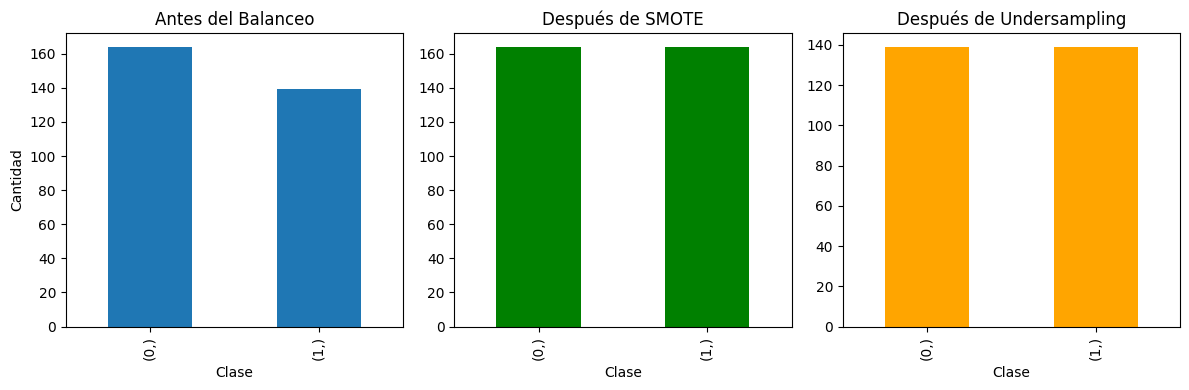

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Mostrar la distribución de clases antes de aplicar técnicas de balance
print("Distribución de clases antes del balanceo:")
print(y.value_counts())
print("-------------------------------------------------------------------------------------------------------\n")

# ---------------- SMOTE (Generación de muestras sintéticas) ----------------
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Mostrar la distribución de clases después de aplicar SMOTE
print("Distribución de clases después de aplicar SMOTE:")
print(y_smote.value_counts())
print("-------------------------------------------------------------------------------------------------------\n")

# ---------------- Undersampling (Reducir la clase mayoritaria) ----------------
undersample = RandomUnderSampler(random_state=42)
X_under, y_under = undersample.fit_resample(X, y)

# Mostrar la distribución de clases después de aplicar Undersampling
print("Distribución de clases después de aplicar Undersampling:")
print(y_under.value_counts())
print("-------------------------------------------------------------------------------------------------------\n")

# Opcional: Ver el tamaño de los dataframes resultantes
print(f"Tamaño de X original: {X.shape}, tamaño de y original: {y.shape}")
print(f"Tamaño de X después de SMOTE: {X_smote.shape}, tamaño de y después de SMOTE: {y_smote.shape}")
print(f"Tamaño de X después de Undersampling: {X_under.shape}, tamaño de y después de Undersampling: {y_under.shape}")

# ---------- Visualización de las distribuciones de clases ----------
plt.figure(figsize=(12, 4))

# Antes del balanceo
plt.subplot(1, 3, 1)
y.value_counts().sort_index().plot(kind='bar')
plt.title('Antes del Balanceo')
plt.xlabel('Clase')
plt.ylabel('Cantidad')

# Después de SMOTE
plt.subplot(1, 3, 2)
y_smote.value_counts().sort_index().plot(kind='bar', color='green')
plt.title('Después de SMOTE')
plt.xlabel('Clase')

# Después de Undersampling
plt.subplot(1, 3, 3)
y_under.value_counts().sort_index().plot(kind='bar', color='orange')
plt.title('Después de Undersampling')
plt.xlabel('Clase')

plt.tight_layout()
plt.show()

## 3. Implementación de los modelos